In [1]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
#Importing the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import log_loss
sns.set_style("darkgrid")
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import SparsePCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense, Bidirectional, Dropout, concatenate
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, auc
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_curve, auc, mean_squared_error,  mean_absolute_error, jaccard_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from scipy.stats import zscore
from scipy import stats

In [4]:
#Loading the dataset
dataset = pd.read_csv('GHL.csv')
dataset = dataset.dropna()

In [5]:
# extract the features and target variable
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [6]:
# preprocess the dataset
scaler = StandardScaler()
X = scaler.fit_transform(X)
le = LabelEncoder()
y = le.fit_transform(y)

In [7]:
from imblearn.over_sampling import SMOTE
#smote = SMOTE(sampling_strategy='auto', k_neighbors=2, random_state=42)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [8]:
# split the dataset into training, testing, and validation datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [9]:
dataset.head()

,RT_level_ini,DANGER,FAULT,RT_temperature.T,HT_temperature.T,RT_level,out_valve_act,dT_rand,inv_valve_act,limiter.y,...,boundary.m_flow_in,dir_valve_act,dt_rand,C_level,C_temperature.T,heater_act,HT_level,limiter1.y,dL_rand,ATTACK
0,0.0,0,0,283.149994,283.149994,0.5,0,0.0,0,283.0,...,0,0,0.0,0.01,273.149994,0,0.1,100.0,0.0,0
1,0.0,0,0,283.149994,283.163330,0.5,0,0.0,0,283.0,...,0,0,0.0,0.01,273.149994,0,0.1,100.0,0.0,0
2,0.0,0,0,283.149994,283.176666,0.5,0,0.0,0,283.0,...,0,0,0.0,0.01,273.149994,0,0.1,100.0,0.0,0
3,0.0,0,0,283.149994,283.189972,0.5,0,0.0,0,283.0,...,0,0,0.0,0.01,273.149994,0,0.1,100.0,0.0,0
4,0.0,0,0,283.149994,283.203247,0.5,0,0.0,0,283.0,...,0,0,0.0,0.01,273.149994,0,0.1,100.0,0.0,0


In [10]:



# Reshape the data for the LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.layers import Layer

# Define Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer='glorot_uniform', trainable=True)

    def call(self, inputs):
        logits = tf.matmul(inputs, self.W)
        attention_weights = tf.nn.softmax(logits, axis=1)
        weighted_sum = tf.reduce_sum(inputs * attention_weights, axis=1)
        return weighted_sum

model = Sequential()
model.add(Dense(units=128, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
# Add attention mechanism after the second LSTM layer
model.add(AttentionLayer())

# Reshape the output of the Attention layer to add the missing timestep dimension
model.add(tf.keras.layers.Reshape((1, -1)))

model.add(LSTM(units=32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])


In [12]:
#Define a learning rate schedular
def scheduler(epoch, lr):
    if epoch <=10:
        return lr #Keep the initial learning rate for the first 200 epochs
    else:
        return lr * tf.math.exp(-0.1) # Reduce the learning rate by a factor of 0.1 after the 200th epoch

In [13]:
lr=0.001
for i in range (100):
    lr=scheduler(i,lr)
    print(i,lr)


0 0.001
1 0.001
2 0.001
3 0.001
4 0.001
5 0.001
6 0.001
7 0.001
8 0.001
9 0.001
10 0.001
11 tf.Tensor(0.00090483745, shape=(), dtype=float32)
12 tf.Tensor(0.0008187308, shape=(), dtype=float32)
13 tf.Tensor(0.0007408183, shape=(), dtype=float32)
14 tf.Tensor(0.0006703201, shape=(), dtype=float32)
15 tf.Tensor(0.00060653075, shape=(), dtype=float32)
16 tf.Tensor(0.00054881175, shape=(), dtype=float32)
17 tf.Tensor(0.0004965854, shape=(), dtype=float32)
18 tf.Tensor(0.00044932903, shape=(), dtype=float32)
19 tf.Tensor(0.0004065697, shape=(), dtype=float32)
20 tf.Tensor(0.0003678795, shape=(), dtype=float32)
21 tf.Tensor(0.00033287113, shape=(), dtype=float32)
22 tf.Tensor(0.00030119426, shape=(), dtype=float32)
23 tf.Tensor(0.00027253185, shape=(), dtype=float32)
24 tf.Tensor(0.00024659702, shape=(), dtype=float32)
25 tf.Tensor(0.0002231302, shape=(), dtype=float32)
26 tf.Tensor(0.00020189656, shape=(), dtype=float32)
27 tf.Tensor(0.00018268357, shape=(), dtype=float32)
28 tf.Tensor(0.00

In [14]:
callback=LearningRateScheduler(scheduler)

In [15]:
history = model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), y_train, 
                    validation_data=(X_val.reshape((X_val.shape[0], X_val.shape[1], 1)), y_val),
                    epochs=100, batch_size=64, verbose=1, callbacks=callback)

Epoch 1/100


2047/2047 [==============================] - 52s 22ms/step - loss: 0.0204 - accuracy: 0.9814 - val_loss: 0.0191 - val_accuracy: 0.9809 - lr: 0.0010
Epoch 2/100
2047/2047 [==============================] - 48s 23ms/step - loss: 0.0183 - accuracy: 0.9817 - val_loss: 0.0191 - val_accuracy: 0.9809 - lr: 0.0010
Epoch 3/100
2047/2047 [==============================] - 43s 21ms/step - loss: 0.0183 - accuracy: 0.9817 - val_loss: 0.0191 - val_accuracy: 0.9809 - lr: 0.0010
Epoch 4/100
2047/2047 [==============================] - 44s 22ms/step - loss: 0.0183 - accuracy: 0.9817 - val_loss: 0.0191 - val_accuracy: 0.9809 - lr: 0.0010
Epoch 5/100
2047/2047 [==============================] - 45s 22ms/step - loss: 0.0183 - accuracy: 0.9817 - val_loss: 0.0191 - val_accuracy: 0.9809 - lr: 0.0010
Epoch 6/100
2047/2047 [==============================] - 43s 21ms/step - loss: 0.0183 - accuracy: 0.9817 - val_loss: 0.0191 - val_accuracy: 0.9809 - lr: 0.0010
Epoch 7/100
2047/2047 [===============

In [16]:
_,acc = model.evaluate(X_test, y_test)
print("Accuracy =", (acc * 100.0), "%")
_,pre = model.evaluate(X_test, y_test)
print("Precision =", (pre * 100.0), "%")
_,f1score = model.evaluate(X_test, y_test)
print("F1 Score =", (f1score * 100.0), "%")
_,rec = model.evaluate(X_test, y_test)
print("Recall =", (rec * 100.0), "%")
_,score = model.evaluate(X_test, y_test)
print('Test score:', (score * 100.0), "%")

1279/1279 [==============================] - 8s 6ms/step - loss: 0.0182 - accuracy: 0.9818
Accuracy = 98.17955493927002 %
1279/1279 [==============================] - 9s 7ms/step - loss: 0.0182 - accuracy: 0.9818
Precision = 98.17955493927002 %
1279/1279 [==============================] - 13s 10ms/step - loss: 0.0182 - accuracy: 0.9818
F1 Score = 98.17955493927002 %
1279/1279 [==============================] - 9s 7ms/step - loss: 0.0182 - accuracy: 0.9818
Recall = 98.17955493927002 %
1279/1279 [==============================] - 9s 7ms/step - loss: 0.0182 - accuracy: 0.9818
Test score: 98.17955493927002 %


1279/1279 [==============================] - 10s 7ms/step
Precision: 0.9818
Recall: 0.9818
Accuracy: 0.9818
F1 Score: 0.0000
Jaccard Score: 0.0000
Log Loss: 0.6562
Confusion Matrix:
[[40179     0]
 [  745     0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     40179
           1       0.00      0.00      0.00       745

    accuracy                           0.98     40924
   macro avg       0.49      0.50      0.50     40924
weighted avg       0.96      0.98      0.97     40924

ROC AUC Score:


C:\Users\hp\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hp\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hp\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

0.5


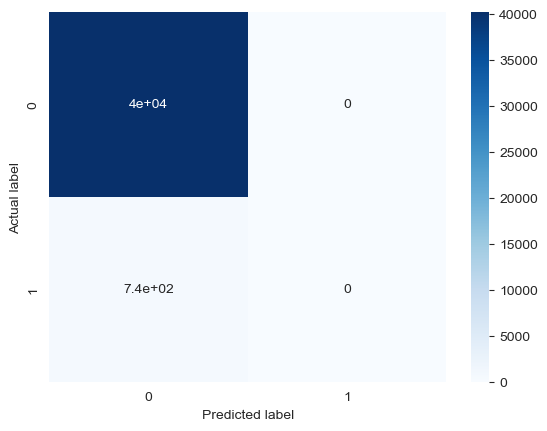

In [17]:
# Evaluate the model
#y_pred = model.predict(X_test_pca.reshape((X_test_pca.shape[0], X_test_pca.shape[1], 1)))
#y_pred = model.predict_classes(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)))
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
#print("Confusion Matrix:")
print('Precision: %.4f' % precision_score(y_test, y_pred, average='micro'))
print('Recall: %.4f' % recall_score(y_test, y_pred, average='micro'))
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
print('F1 Score: %.4f' % f1_score(y_test, y_pred))
print('Jaccard Score: %.4f' % jaccard_score(y_test, y_pred))
print('Log Loss: %.4f' % log_loss(y_test, y_pred))
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_pred))

1279/1279 [==============================] - 9s 7ms/step


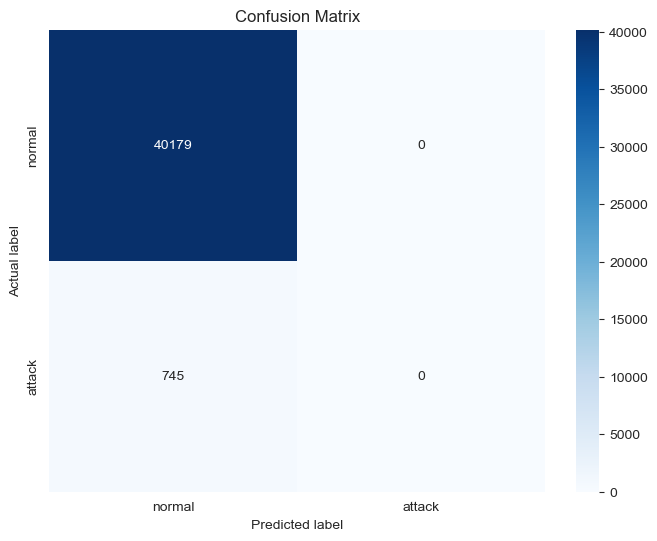

Precision: 0.9818
Recall: 0.9818
Accuracy: 0.9818
F1 Score: 0.0000
Jaccard Score: 0.0000
Log Loss: 0.6562

Confusion Matrix:
[[40179     0]
 [  745     0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     40179
           1       0.00      0.00      0.00       745

    accuracy                           0.98     40924
   macro avg       0.49      0.50      0.50     40924
weighted avg       0.96      0.98      0.97     40924


ROC AUC Score:
0.5


C:\Users\hp\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hp\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hp\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, jaccard_score, log_loss, classification_report, roc_auc_score

# Example: Assuming y_test and y_pred are defined
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)

# Define class labels
class_labels = ['normal', 'attack']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', 
            xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Print evaluation metrics
print('Precision: %.4f' % precision_score(y_test, y_pred, average='micro'))
print('Recall: %.4f' % recall_score(y_test, y_pred, average='micro'))
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
print('F1 Score: %.4f' % f1_score(y_test, y_pred))
print('Jaccard Score: %.4f' % jaccard_score(y_test, y_pred))
print('Log Loss: %.4f' % log_loss(y_test, y_pred))

print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred))


In [19]:
# Calculate Z-score
training_error = history.history['loss'][-1]
testing_error = history.history['loss'][-1]
validation_error = history.history['val_loss'][-1]
z_score = (training_error - validation_error) / np.std(history.history['val_loss'])
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Training Error:", training_error)
print("Validation Error:", validation_error)
print("Z-Score:", z_score)


Mean Squared Error: 0.018204476590753593
Training Error: 0.018296221271157265
Validation Error: 0.019059253856539726
Z-Score: -inf


C:\Users\hp\AppData\Local\Temp\ipykernel_7672\2143376901.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  z_score = (training_error - validation_error) / np.std(history.history['val_loss'])


In [20]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Compute predictions for the test dataset
y_test_pred = model.predict(X_test)
y_test_pred = (y_test_pred > 0.5)  # Convert predictions to binary

# Calculate Mean Squared Error for the test dataset
test_mse = mean_squared_error(y_test, y_test_pred)

# Calculate training and validation errors from history
training_error = history.history['loss'][-1]
validation_error = history.history['val_loss'][-1]

# Calculate the mean and standard deviation of training and validation errors
val_loss_std = np.std(history.history['val_loss'])
train_loss_mean = np.mean(history.history['loss'])

# Calculate Z-score for the test error
# Note: This is a relative measure, using training error and validation loss as benchmarks
z_score = (test_mse - train_loss_mean) / val_loss_std

# Print results
print("Test Mean Squared Error:", test_mse)
print("Training Error:", training_error)
print("Validation Error:", validation_error)
print("Z-Score (test error):", z_score)

1279/1279 [==============================] - 8s 6ms/step
Test Mean Squared Error: 0.018204476590753593
Training Error: 0.018296221271157265
Validation Error: 0.019059253856539726
Z-Score (test error): -inf


C:\Users\hp\AppData\Local\Temp\ipykernel_7672\4279556638.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  z_score = (test_mse - train_loss_mean) / val_loss_std


AUC: 0.5


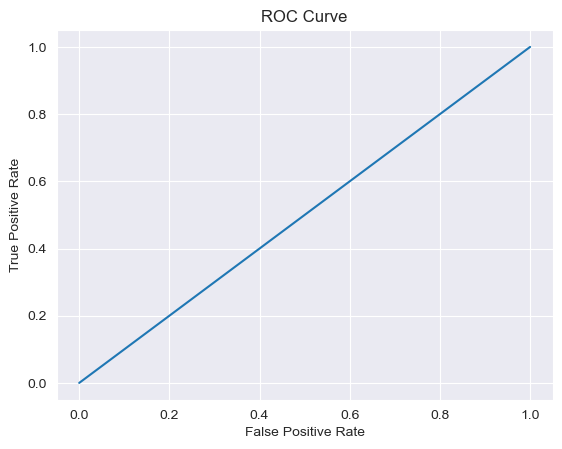

In [21]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plot.bar(figsize=(20,8))
print("AUC:", roc_auc)


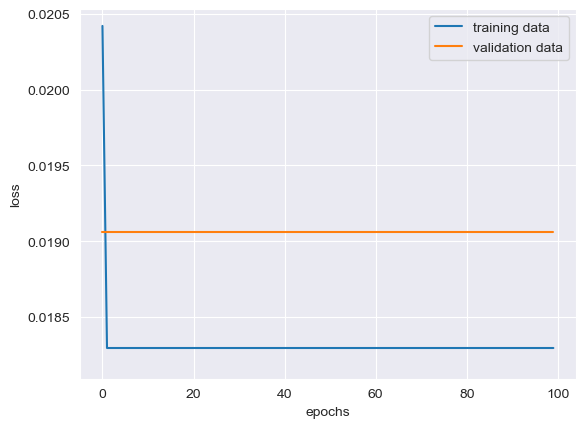

In [22]:
plt.plot(history.history['loss'], label="training data")
#plt.plot(history.history['loss'], label="testing data")
plt.plot(history.history['val_loss'], label="validation data" )
#plt.plot([training_error] * len(history.history['loss']), '--')
#plt.plot([validation_error] * len(history.history['loss']), '--')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.plot([mse])

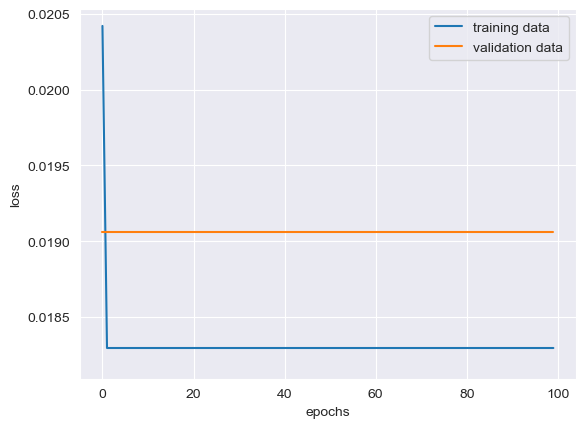

In [23]:
plt.plot(history.history['loss'], label="training data")
#plt.plot(history.history['loss'], label="testing data")
plt.plot(history.history['val_loss'], label="validation data" )
#plt.plot([training_error] * len(history.history['loss']), '--')
#plt.plot([validation_error] * len(history.history['loss']), '--')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.plot([mse])

In [24]:
acc= history.history['accuracy']
val_acc=history.history['val_accuracy']
#epochs=range(1, len(loss)+1)
plt.plot(epochs,acc,'y', label='training accuracy')
plt.plot(epochs,val_acc,'g', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

NameError: name 'epochs' is not defined

In [ ]:
loss= history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1, len(loss)+1)
plt.plot(epochs, acc,'y', label='training data')
plt.plot(epochs,val_acc,'g', label='validation data')
plt.title('Training and Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
acc= history.history['accuracy']
val_acc=history.history['val_accuracy']
#epochs=range(1, len(loss)+1)
plt.plot(epochs,acc,'y', label='training accuracy')
plt.plot(epochs,val_acc,'g', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:

# Predict probabilities for both models
pred = model.predict(X_test)


In [ ]:
# Compute ROC curve and area under curve (AUC) for both models
fpr, tpr, thresholds = roc_curve(y_test, pred)
auc = auc(fpr, tpr)

In [ ]:
plt.plot(fpr, tpr, label='RNN (AUC = {:.4f})'.format(auc))
plt.plot([0, 1], color='orange', lw=2, linestyle='--')
plt.xlabel('1-Specificity (FPR)')
plt.ylabel('Sensitivity (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()